In [1]:
import warnings
warnings.filterwarnings('ignore') # to avoid warnings

import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys 

"""
Sklearn Libraries
"""
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

"""
Transformer Libraries
"""
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import BertTokenizer,  AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset

"""
Pytorch Libraries
"""
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

sys.path.append('../')
from src.utilities.config_ import train_data_path, combined_data_path
import src.utilities.utils as utils

In [2]:
# read csv
data = pd.read_csv(os.path.join(train_data_path, "finance-dataset.csv"),
                   encoding='latin-1', 
                    names=['label', 'text']).iloc[1:]

# Convert labels to integers
label_to_int = {'positive': 0, 'neutral': 1, 'negative': 2}
data['label'] = data['label'].map(label_to_int)

data

,label,text
1,1,"According to Gran , the company has no plans t..."
2,1,Technopolis plans to develop in stages an area...
3,2,The international electronic industry company ...
4,0,With the new production plant the company woul...
5,0,According to the company 's updated strategy f...
...,...,...
4842,2,LONDON MarketWatch -- Share prices ended lower...
4843,1,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4844,2,Operating profit fell to EUR 35.4 mn from EUR ...
4845,2,Net sales of the Paper segment decreased to EU...


In [7]:
# Load the tokenizer for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Load the DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

In [8]:
# Convert pandas DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(data)

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=64)  # You can adjust the max_length as needed

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Rename the label column to "labels" for the trainer
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

# Remove unnecessary columns
tokenized_dataset = tokenized_dataset.remove_columns(["text"])

# Convert to torch tensors
tokenized_dataset.set_format("torch")

# Split the dataset into train and test sets
train_test_split = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

Map: 100%|██████████| 4846/4846 [00:01<00:00, 2573.15 examples/s]


In [9]:
# Define training arguments with evaluation steps
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,  # Set a high number of epochs to allow for early stopping
    per_device_train_batch_size=8,  # Adjust based on your memory
    per_device_eval_batch_size=16,  # Adjust based on your memory
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='../logs',
    logging_steps=100,  # Log every 100 steps
    evaluation_strategy="steps",  # Evaluate every 'eval_steps'
    eval_steps=100,  # Evaluation interval, adjust based on your dataset size
    log_level="error",
)

In [11]:
from transformers import TrainerCallback, TrainerState, TrainerControl
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, threshold: float, metric: str = "eval_accuracy"):
        self.threshold = threshold
        self.metric = metric

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        if state.log_history and self.metric in state.log_history[-1]:
            accuracy = state.log_history[-1][self.metric]
            if accuracy > self.threshold:
                control.should_training_stop = True
                print(f"Stopping training as {self.metric} has reached {accuracy}")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

# Define the custom callback with your threshold
early_stopping_callback = EarlyStoppingCallback(threshold=0.85, metric="eval_accuracy")

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[early_stopping_callback],
    compute_metrics=compute_metrics,  # Define a compute_metrics function to calculate accuracy
)

# Train the model
trainer.train()

{'loss': 0.8088, 'learning_rate': 1e-05, 'epoch': 0.21}
{'eval_loss': 0.765763521194458, 'eval_accuracy': 0.6597938144329897, 'eval_runtime': 22.5074, 'eval_samples_per_second': 43.097, 'eval_steps_per_second': 2.71, 'epoch': 0.21}
{'loss': 0.642, 'learning_rate': 2e-05, 'epoch': 0.41}
{'eval_loss': 0.5475639700889587, 'eval_accuracy': 0.7855670103092783, 'eval_runtime': 35.1485, 'eval_samples_per_second': 27.597, 'eval_steps_per_second': 1.735, 'epoch': 0.41}
{'loss': 0.5052, 'learning_rate': 3e-05, 'epoch': 0.62}
{'eval_loss': 0.4382946491241455, 'eval_accuracy': 0.8257731958762886, 'eval_runtime': 27.4735, 'eval_samples_per_second': 35.307, 'eval_steps_per_second': 2.22, 'epoch': 0.62}
{'loss': 0.4709, 'learning_rate': 4e-05, 'epoch': 0.82}
{'eval_loss': 0.45776626467704773, 'eval_accuracy': 0.8123711340206186, 'eval_runtime': 29.9672, 'eval_samples_per_second': 32.369, 'eval_steps_per_second': 2.036, 'epoch': 0.82}
{'loss': 0.4326, 'learning_rate': 5e-05, 'epoch': 1.03}
{'eval_loss

TrainOutput(global_step=1400, training_loss=0.38261713300432476, metrics={'train_runtime': 1512.0555, 'train_samples_per_second': 10.254, 'train_steps_per_second': 1.283, 'train_loss': 0.38261713300432476, 'epoch': 2.89})

In [13]:
training_df =  pd.DataFrame(trainer.state.log_history)
# Forward fill NaN values in 'loss' and 'learning_rate' columns
training_df['loss'].fillna(method='ffill', inplace=True)
training_df['learning_rate'].fillna(method='ffill', inplace=True)
training_df = training_df[["loss", "learning_rate", "epoch", "step", "eval_loss", "eval_accuracy", "eval_runtime", "eval_samples_per_second", "eval_steps_per_second"]]
training_log =  training_df.dropna()
training_log

,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second
1,0.8088,0.000010,0.21,100,0.765764,0.659794,22.5074,43.097,2.710
3,0.6420,0.000020,0.41,200,0.547564,0.785567,35.1485,27.597,1.735
5,0.5052,0.000030,0.62,300,0.438295,0.825773,27.4735,35.307,2.220
7,0.4709,0.000040,0.82,400,0.457766,0.812371,29.9672,32.369,2.036
9,0.4326,0.000050,1.03,500,0.475588,0.836082,20.5600,47.179,2.967
11,0.3713,0.000047,1.24,600,0.653051,0.816495,28.8547,33.617,2.114
13,0.3678,0.000043,1.44,700,0.561310,0.839175,21.7111,44.678,2.810
15,0.3701,0.000040,1.65,800,0.670092,0.814433,21.3683,45.394,2.855
17,0.3654,0.000036,1.86,900,0.676544,0.781443,21.5132,45.089,2.835
19,0.3011,0.000033,2.06,1000,0.722972,0.812371,21.7817,44.533,2.801


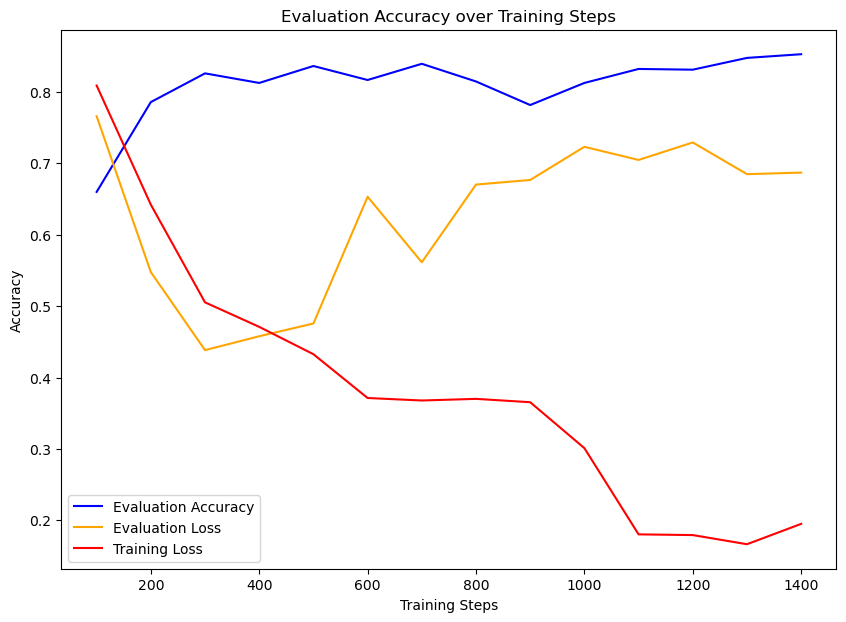

In [14]:
# Create a dataframe for training log history
training_df =  pd.DataFrame(trainer.state.log_history)

# Forward fill NaN values in 'loss' and 'learning_rate' columns
training_df['loss'].fillna(method='ffill', inplace=True)
training_df['learning_rate'].fillna(method='ffill', inplace=True)
training_df = training_df[["loss", "learning_rate", "epoch", "step", "eval_loss", "eval_accuracy", "eval_runtime", "eval_samples_per_second", "eval_steps_per_second"]]
training_log =  training_df.dropna()

# Plot the training and evaluation accuracy
training_steps = training_log[training_log['step'].notna()]['step']
eval_accuracy = training_log[training_log['eval_accuracy'].notna()]['eval_accuracy']
eval_loss = training_log[training_log['eval_loss'].notna()]['eval_loss']
train_loss = training_log[training_log['loss'].notna()]['loss']

plt.figure(figsize=(10, 7))
plt.plot(training_steps, eval_accuracy, label='Evaluation Accuracy', color='blue')
plt.plot(training_steps, eval_loss, label='Evaluation Loss', color='orange')
plt.plot(training_steps, train_loss, label='Training Loss', color='red')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy over Training Steps')
plt.legend()
plt.show()


In [23]:
# Predict on the test set
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)


100%|██████████| 61/61 [00:11<00:00,  5.08it/s]


In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Define the metric function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Evaluate the model
metrics = compute_metrics(predictions)
print(metrics)

{'accuracy': 0.8536082474226804, 'f1': 0.8535255427728373, 'precision': 0.8534628927183862, 'recall': 0.8536082474226804}


In [25]:
# Your new text
new_text = ["This is a sample financial news article. The market is looking bad.", "Market is looking great now"]

# Tokenize the new text
inputs = tokenizer(new_text, padding='max_length', truncation=True, max_length=64, return_tensors="pt")

# Move inputs to the appropriate device (e.g., CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {key: value.to(device) for key, value in inputs.items()}

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

# Map predictions to labels
int_to_label = {0: 'positive', 1: 'neutral', 2: 'negative'}
predicted_labels = [int_to_label[pred.item()] for pred in predictions]

print(predicted_labels)


['negative', 'positive']


In [30]:
# Define the path to save the model and tokenizer
save_directory = "../model/distilbert/"

# Save the model
model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

('../model/distilbert/tokenizer_config.json',
 '../model/distilbert/special_tokens_map.json',
 '../model/distilbert/vocab.txt',
 '../model/distilbert/added_tokens.json')

In [3]:
# Define the path to the saved directory
save_directory = "../model/distilbert/"

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(save_directory)

# Load the model
model = DistilBertForSequenceClassification.from_pretrained(save_directory)

In [32]:
# Define dummy training arguments (only `per_device_eval_batch_size` is relevant here)
training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=16,  # Adjust based on your memory
)

# Create Trainer instance with the loaded model
trainer = Trainer(
    model=model,
    args=training_args
)

# Predict on the test dataset
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

# Generate the classification report
report = classification_report(true_labels, preds, target_names=['negative', 'neutral', 'positive'])
accuracy = accuracy_score(true_labels, preds)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(true_labels, preds, labels=[0, 1, 2])

# Plot the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('DistilBERT Confusion Matrix')
plt.show()

Accuracy: 0.8536082474226804
Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.80      0.80       286
     neutral       0.89      0.89      0.89       573
    positive       0.79      0.80      0.80       111

    accuracy                           0.85       970
   macro avg       0.83      0.83      0.83       970
weighted avg       0.85      0.85      0.85       970



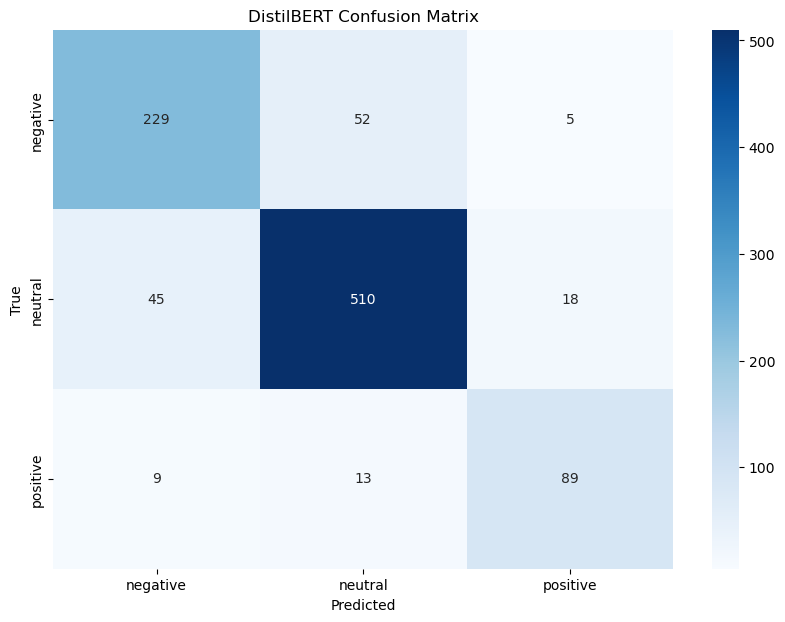

In [36]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

# Extract the true labels
true_labels = predictions.label_ids

# Generate the classification report
report = classification_report(true_labels, preds, target_names=['negative', 'neutral', 'positive'])
accuracy = accuracy_score(true_labels, preds)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(true_labels, preds, labels=[0, 1, 2])

# Plot the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('DistilBERT Confusion Matrix')
plt.show()

In [4]:
def predict_with_distilbert(
        df,
        loaded_model,
        loaded_tokenizer
):
    # New text data to predict
    titles = list(df['title'])

    # Tokenize the new text
    inputs = loaded_tokenizer(titles, padding='max_length', truncation=True, max_length=64, return_tensors="pt")

    # Move inputs to the appropriate device (e.g., CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loaded_model.to(device)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    
    # Make predictions
    loaded_model.eval()
    with torch.no_grad():
        outputs = loaded_model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        
    # Map predictions to labels
    int_to_label = {0: 'positive', 1: 'neutral', 2: 'negative'}
    predicted_labels = [int_to_label[pred.item()] for pred in predictions]

    df["label"] = predicted_labels
    
    return df

In [7]:
# Define the path to the saved directory
save_directory = "../model/distilbert/"

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(save_directory)

# Load the model
model = DistilBertForSequenceClassification.from_pretrained(save_directory)

df = data.copy()
df = df.drop(columns="label")
df = df.rename(columns={"text" : "title"})
df = df.iloc[-20:]

In [8]:
new_df = predict_with_distilbert(df, model, tokenizer)
new_df

,title,label
4827,Mobile communication and wireless broadband pr...,neutral
4828,External net sales from the printing business ...,negative
4829,"Seven-month sales of Ragutis , which is contro...",negative
4830,The OMX Helsinki index was 0.33 pct lower at 9...,negative
4831,"The OMX Helsinki index was down 0.34 pct at 8,...",negative
4832,Repeats sees 2008 operating profit down y-y ( ...,negative
4833,Comparable operating profit totaled EUR 4.7 mn...,negative
4834,In Finland 's Hobby Hall 's sales decreased by...,negative
4835,Hobby Hall 's sales decrease 26 pct due to imp...,negative
4836,In the Baltic states the company reports net s...,negative


In [81]:
df = utils.load(os.path.join(combined_data_path, "combined_data.feather"))
df

,title,date,url,category,label,source
0,"Gold, Silver Q3 Technical Forecast: Gold's Ran...",30-06-2024,https://www.dailyfx.com/analysis/gold-silver-q...,forex,neutral,dailyfx
1,Bitcoin Q3 Fundamental Outlook – Short-Term Mu...,30-06-2024,https://www.dailyfx.com/news/bitcoin-q3-fundam...,forex,positive,dailyfx
2,Crude Oil Q3 Technical Forecast: Narrowing Pri...,29-06-2024,https://www.dailyfx.com/analysis/crude-oil-q3-...,forex,neutral,dailyfx
3,Equities Q3 Fundamental Outlook: Bullish Momen...,29-06-2024,https://www.dailyfx.com/news/equities-q3-funda...,forex,neutral,dailyfx
4,British Pound Q3 Technical Forecast: GBP/USD E...,29-06-2024,https://www.dailyfx.com/analysis/british-pound...,forex,neutral,dailyfx
...,...,...,...,...,...,...
1044,"Increase in exports, improvement in CAD, mnfg ...",30-06-2024,https://economictimes.indiatimes.com//news/eco...,economy,positive,econtimes
1045,India initiates anti-dumping probe into import...,30-06-2024,https://economictimes.indiatimes.com//news/eco...,economy,neutral,econtimes
1046,2015 skilling policy to be replaced with new one,30-06-2024,https://economictimes.indiatimes.com//news/eco...,economy,neutral,econtimes
1047,India is witnessing high foreign remittances &...,30-06-2024,https://economictimes.indiatimes.com//news/eco...,economy,positive,econtimes
